# Projet 4 : Prédiction de la consommation d'énergie et des émissions de C02 dans la ville de Seattle

In [1]:
#%pip install seaborn
#%pip install missingno
# %pip install scikit-learn
# %pip install polars

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import polars as pl

from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, get_scorer_names
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_columns", None) #afficher toutes les colonnes
pd.set_option("display.max_rows", 200) #afficher X lignes
pd.set_option('display.max_colwidth', None) #afficher tout le contenu des colonnes


# Etape 1 : Analyse exploratoire du dataset

In [3]:
raw_data = pd.read_csv("2016_Building_Energy_Benchmarking.csv")

In [4]:
raw_data.shape
raw_data.head()

(3376, 46)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Le dataset compte 3376 propriétés, composées de un ou plusieurs batiments, et décrites via 46 variables.

In [5]:
raw_data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

### On retire les colonnes vides ou sans indications

<Axes: >

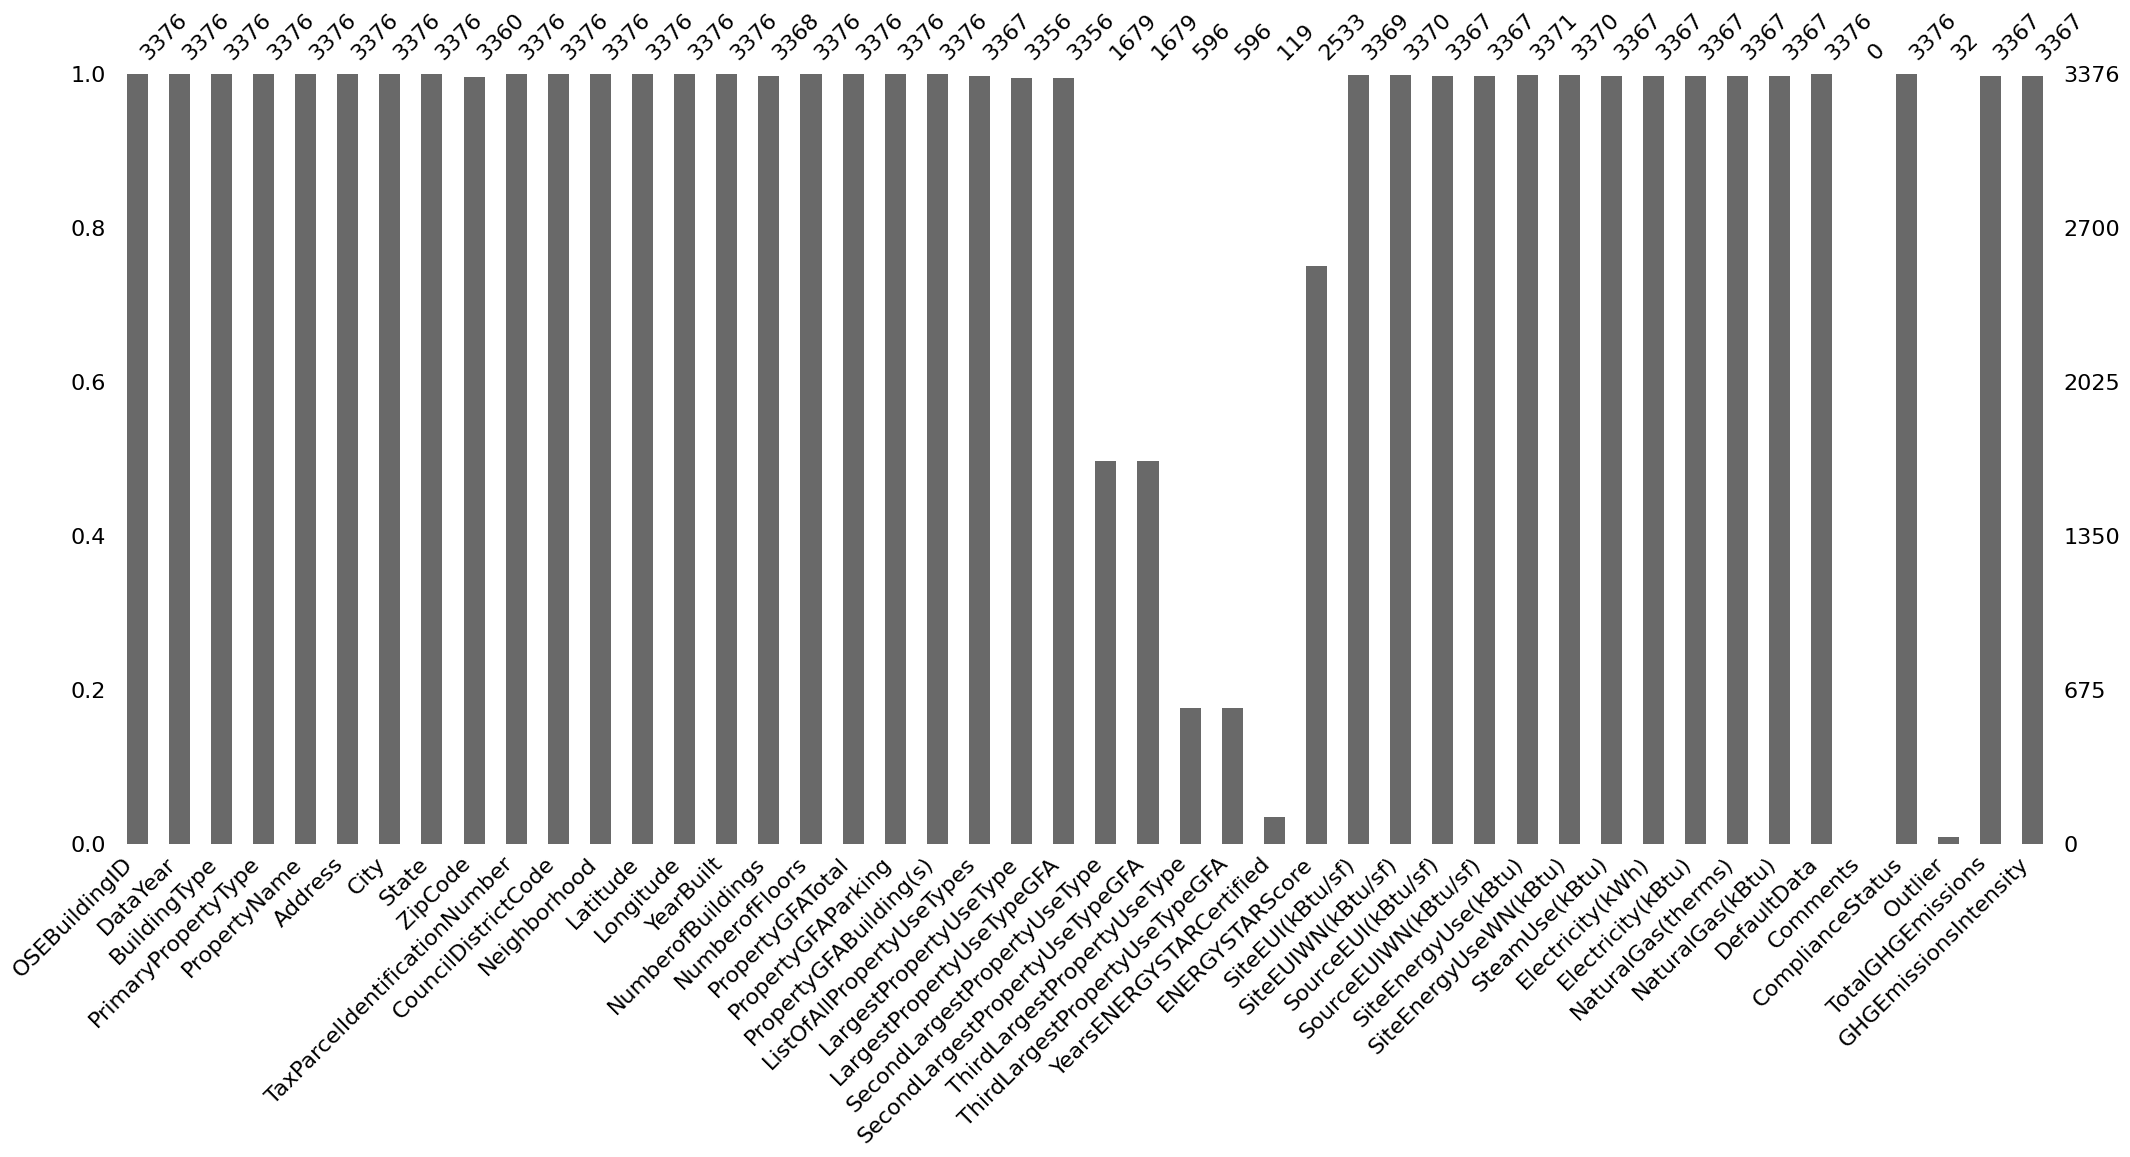

In [6]:
msno.bar(raw_data)

Aucune information n'est disponible dans la source consernant la colonne 'DefaultData' et la colonne 'Comments' ne contient que des nan. On les enlève donc du dataset. 

In [7]:
raw_data.drop(['Comments','DefaultData'],axis = 1, inplace=True)

In [8]:
raw_data.shape

(3376, 44)

### Types de propriétés : est-ce que tous ces types rentrent dans la catégorie d'intérêt i.e. les batiments non résidentiels?

In [9]:
raw_data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

- 'Nonresidential COS' concerne les batiments non résidentiels qui appartiennent ou qui sont gérés par la ville de Seattle (COS = City of Seattle)
- 'Nonresidential WA' concerne les batiments non résidentiels qui appartiennent ou qui sont gérés par l'état de Washington
- 'Multifamily HR (10+)', 'Multifamily MR (5-9)' and 'Multifamily LR (1-4)' correspondent à des zones résidentielles dont les bâtiments ne sont pas étudiés dans ce projet. 
- "SPS-District K-12" correspondent à des bâtiments scolaires publics de la maternelle au lycée (SPS = Seattle Public Schools). Il ne s'agit pas de bâtiments résidentiels. 
- Dans la catégorie "Campus", certains batiments ont une activitée mixte résidentielle/non résidentielle. On attend d'avoir davantage d'informations pour prendre une décision / faire un tri.

On commence donc par retirer les propriétées de type "Multifamily" : 

In [10]:
raw_data = raw_data.loc[~raw_data['BuildingType'].str.contains('Multifamily')]
raw_data.shape

(1668, 44)

Cette opération a enlevé environ la moitié des données

#### Tri des propriétés de type 'Campus'

In [11]:
raw_data.loc[raw_data['BuildingType'] == "Campus","ListOfAllPropertyUseTypes"].unique()

array(['Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office',
       'College/University',
       'Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility',
       'Other',
       'Food Sales, Multifamily Housing, Office, Other - Education, Other - Restaurant/Bar, Pre-school/Daycare, Restaurant, Retail Store, Supermarket/Grocery Store',
       'Data Center, Office, Parking, Restaurant, Retail Store',
       'Other, Parking', 'Manufacturing/Industrial Plant', 'K-12 School',
       'Food Sales, Office, Restaurant, Retail Store, Self-Storage Facility, Social/Meeting Hall',
       'Bar/Nightclub, Food Sales, Multifamily Housing, Restaurant, Retail Store, Self-Storage Facility',
       'Food Sales, Office, Restaurant', 'College/University, Parking',
       'Adult Education', 'K-12 School, Parking'], dtype=object)

Certaines propriétés de type 'Campus' sont non résidentielles ('Office', 'K-12 School') mais d'autres ont un type inconnu et d'autres encore sont de type résidentiel. On enlève celles qui sont de type résidentiel : 

In [12]:
raw_data = raw_data.loc[~((raw_data['BuildingType'] == "Campus") & (raw_data['ListOfAllPropertyUseTypes'].str.contains("Multifamily", case = False)))]
raw_data.shape

(1666, 44)

In [13]:
len(raw_data.loc[raw_data['BuildingType'] == "Campus"])

22

La catégorie 'Campus' regroupe 22 propriétés dont certaines ont une liste d'utilisation inconnue ('Other') : 

In [14]:
raw_data.loc[raw_data['BuildingType'] == "Campus"]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,Seattle,WA,98108.0,0022000005,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,NaN,8.0,221.699997,233.100006,388.200012,400.299988,4.483853e+08,4.716139e+08,0.000000e+00,4.410208e+07,150476283.0,2.979090e+06,297909000.0,Compliant,NaN,16870.98,34.09
105,172,2016,Campus,University,SSCC MAIN CAMPUS,6000 16th Ave SW,Seattle,WA,98106.0,6171900005,1,DELRIDGE,47.54700,-122.35307,1970,27.0,2,441071,0,441071,College/University,College/University,483000.0,NaN,NaN,NaN,NaN,NaN,NaN,79.300003,85.199997,192.800003,202.600006,3.830174e+07,4.115173e+07,0.000000e+00,7.419278e+06,25314575.0,1.298717e+05,12987166.0,Compliant,NaN,866.23,1.96
128,211,2016,Campus,University,NSCC MAIN CAMPUS,9600 COLLEGE WAY N,Seattle,WA,98103.0,3226049021,5,NORTHWEST,47.69936,-122.33401,1970,11.0,2,694072,111625,582447,College/University,College/University,667335.0,NaN,NaN,NaN,NaN,NaN,NaN,53.799999,56.099998,161.199997,167.000000,3.589148e+07,3.741080e+07,0.000000e+00,9.803878e+06,33450832.0,2.440648e+04,2440648.0,Compliant,NaN,362.82,0.52
162,261,2016,Campus,Large Office,South Park,1420 S Trenton,Seattle,WA,98108.0,7883608601,1,GREATER DUWAMISH,47.52429,-122.31234,1980,14.0,2,334368,31874,302494,"Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility",Office,240984.0,Laboratory,72963.0,Other - Utility,16766.0,NaN,NaN,159.899994,161.899994,451.200012,453.299988,5.346668e+07,5.413607e+07,0.000000e+00,1.328294e+07,45321378.0,8.145300e+04,8145300.0,Compliant,NaN,748.55,2.24
195,315,2016,Campus,Other,P66 Bell Harbor International Conference Center & Cruise Terminal.,2225 Alaskan Way,Seattle,WA,98125.0,7666202325,7,DOWNTOWN,47.61137,-122.34947,1995,4.0,3,215476,0,215476,Other,Other,217088.0,NaN,NaN,NaN,NaN,NaN,NaN,110.599998,113.300003,248.899994,251.800003,2.401777e+07,2.460637e+07,0.000000e+00,4.041282e+06,13788853.0,1.022892e+05,10228916.0,Compliant,NaN,639.39,2.97
301,432,2016,Campus,Mixed Use Property,Securities Building Campus,1904 Third Avenue,Seattle,WA,98101.0,1977201315,7,DOWNTOWN,47.61229,-122.33903,1913,3.0,10,258497,0,258497,"Data Center, Office, Parking, Restaurant, Retail Store",Parking,155000.0,Office,145594.0,Retail Store,103200.0,NaN,NaN,77.300003,80.099998,214.600006,218.000000,2.077980e+07,2.153613e+07,3.902781e+06,4.946370e+06,16877013.0,0.000000e+00,0.0,Compliant,NaN,418.90,1.62
340,477,2016,Campus,Other,Weintraub/Hutchinson/Thomas,1100 Fairview Ave N,Seattle,WA,98109.0,1984200455,3,LAKE UNION,47.62855,-122.33035,1997,1.0,5,535947,0,535947,"Other, Parking",Other,535947.0,Parking,103983.0,NaN,NaN,NaN,NaN,245.100006,255.800003,509.399994,515.599976,1.313739e+08,1.371061e+08,0.000000e+00,1.894122e+07,64627449.0,6.674642e+05,66746425.0,Compliant,NaN,3995.45,7.45
661,19491,2016,Campus,Other,Pacific Multiforms Inc- Campus,6606 Urusla Pl. South,Seattle,WA,98155.0,0005200056,2,GREATER DUWAMISH,47.54134,-122.30529,1994,3.0,1,22800,0,22800,Manufacturing/Industrial Plant,Manufacturing/Industrial Plant,22800.0,NaN,NaN,NaN,

Après lecture des 22 noms de propriétés et après avoir mené quelques vérifications sur internet, on considère qu'aucune de ces propriétés n'est à usage résidentiel, même partiellement.

#### Quartiers de la ville

In [15]:
raw_data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

Il y a des doublons à cause d'erreurs de format : minuscules / majuscules

In [16]:
raw_data['Neighborhood'] = raw_data['Neighborhood'].str.upper()
raw_data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

On ne sait pas trop à ce stade si DELRIDGE et DELRIDGE NEIGHBORHOODS représentent la même zone. Mais on pourrait les fusionner en DELRIDGE. En attente de savoir si c'est une variable importante pour la suite. 

#### Surface

La surface est donnée par 3 variables : 'PropertyGFATotal', 'PropertyGFAParking' et 'PropertyGFABuilding(s)'. <br>
GFA = gross floor area. La surface est données en <i> feet square</i>. <br>
Total = Parking + Building(s) : 

In [17]:
(raw_data['PropertyGFATotal'] == (raw_data['PropertyGFAParking'] + raw_data['PropertyGFABuilding(s)'])).sum() == len(raw_data)

np.True_

Ce qui nous intéresse, pour des calculs de consommation d'énergie par unité de surface, c'est 'PropertyGFABuilding(s)' car les parkings de sont pas chauffés. <br> 
Remarque : on a aussi la surface du plus grand, du second plus grand et du troisième plus grand batiment de la propriété. Ces données ne sont utiles que si 'PropertyGFABuilding(s)' n'est pas renseignée mais ce n'est jamais le cas :

In [18]:
raw_data['PropertyGFABuilding(s)'].isnull().sum()

np.int64(0)

In [19]:
raw_data['PropertyGFATotal'].isnull().sum()

np.int64(0)

In [20]:
raw_data['PropertyGFATotal'].describe()

count    1.666000e+03
mean     1.188756e+05
std      2.975350e+05
min      1.128500e+04
25%      2.943725e+04
50%      4.928950e+04
75%      1.050902e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64

Il n'y a pas de NaN ou de valeurs nulles. Il est toutefois difficile de conclure concernant de potentiels outliers.

#### Consommation d'énergie

- 'SiteEUI(kBtu/sf)' : EUI = Energy Use Intensity. C'est la consommation d'énergie (en milliers de British termal units) par unité de surface (squere foot)
- 'SiteEUIWN(kBtu/sf)' est la consommation d'énergie mais rectifiée par rapport à la météo du lieu. Cela permet de comparer des batiments qui sont affectés par des conditions climatiques différentes. 
- 'SourceEUI(kBtu/sf)' et 'SourceEUIWN(kBtu/sf)' tiennent compte de l'énergie perdue lors de sa production et de son transport.

#### Emissions de gaz à effet de serre

- 'TotalGHGEmissions' : GHG = greenhousegas. Exprimé en tonnes d'équivalent C02.
- 'GHGEmissionsIntensity' : émissions de gaz à affet de serre en kilogrammes d'équivalent carbone par square foot.
- L'émission de GES est dépendante de la consommation énergétique

#### Compliance Status et Outlier

In [21]:
raw_data['ComplianceStatus'].unique()
raw_data['Outlier'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [22]:
len(raw_data.loc[(raw_data['ComplianceStatus'] != 'Compliant')|(~raw_data['Outlier'].isnull())])/len(raw_data)*100

7.202881152460984

Vu le faible pourcentage de propriétés concernées et la quantité de données restante, on peut tout simplement enlever les propriétés qui ont un statut qui n'est pas "Compliant" i.e. qui contient des erreurs ou des données manquantes, ou qui sont des outliers. 

In [23]:
raw_data = raw_data.loc[~(raw_data['ComplianceStatus'] != 'Compliant')|(~raw_data['Outlier'].isnull())]
raw_data.shape

(1563, 44)

### Analyse exploratoire simple

Variables cibles : - TotalGHGEmissions et - SourceEnergyUseWN(kBtu)

<Axes: ylabel='TotalGHGEmissions'>

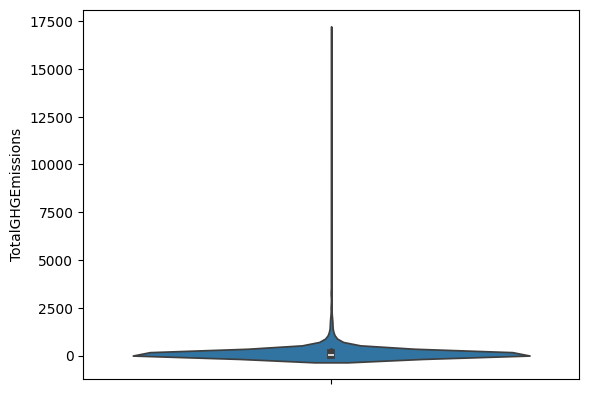

In [24]:
sns.violinplot(raw_data['TotalGHGEmissions'])

<Axes: ylabel='SiteEnergyUseWN(kBtu)'>

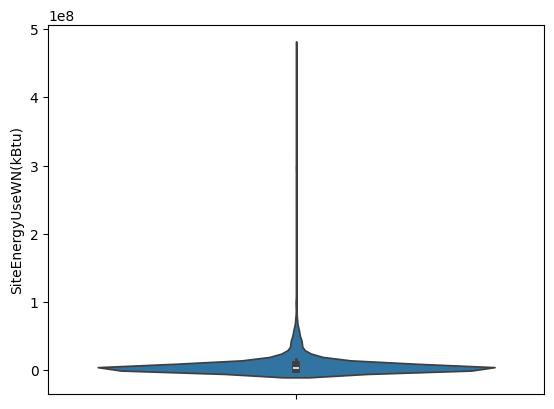

In [25]:
sns.violinplot(raw_data['SiteEnergyUseWN(kBtu)'])

<Figure size 800x500 with 0 Axes>

<Axes: xlabel='DecadeBuilt'>

Text(0.5, 0, 'Decade')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Année de construction par décade')

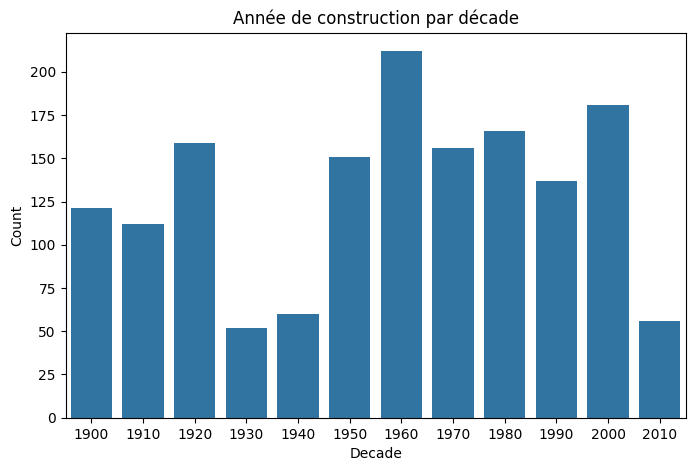

In [26]:
# Create a new column for decade bins
data_for_plot = raw_data.copy()
data_for_plot["DecadeBuilt"] = (data_for_plot["YearBuilt"] // 10) * 10  # Groups years into decades

# Count occurrences per decade
decade_counts = data_for_plot["DecadeBuilt"].value_counts().sort_index()

# Plot barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=decade_counts.index.astype(str), y=decade_counts.values)
plt.xlabel("Decade")
plt.ylabel("Count")
plt.title("Année de construction par décade")
plt.show()

In [27]:
raw_data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GH

<Figure size 1000x500 with 0 Axes>

<Axes: >

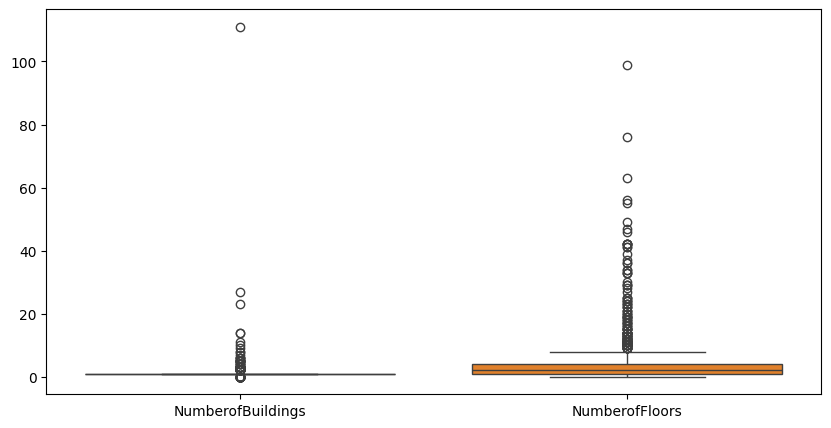

In [28]:
# Select only numeric columns
df_numeric = raw_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "Numberof" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'PropertyGFATotal'),
  Text(1, 0, 'PropertyGFAParking'),
  Text(2, 0, 'PropertyGFABuilding(s)'),
  Text(3, 0, 'LargestPropertyUseTypeGFA'),
  Text(4, 0, 'SecondLargestPropertyUseTypeGFA'),
  Text(5, 0, 'ThirdLargestPropertyUseTypeGFA')])

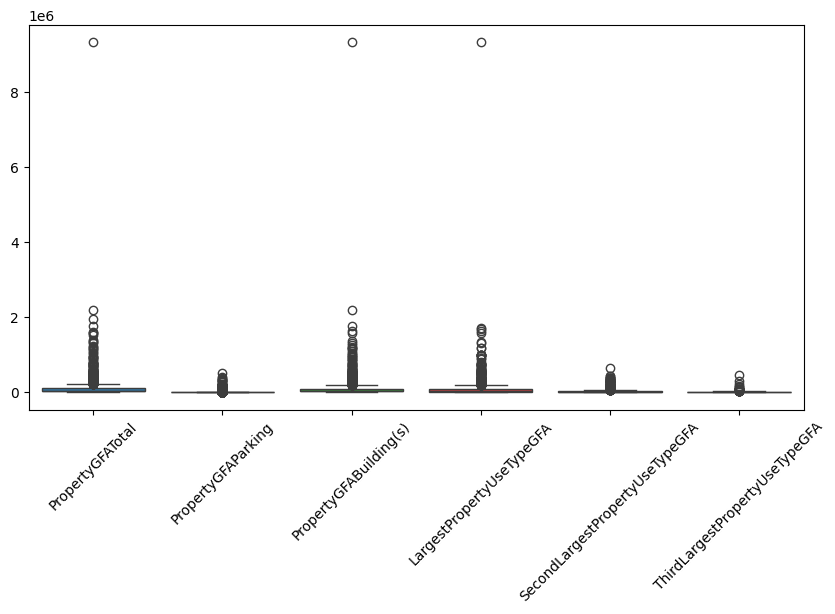

In [29]:
# Select only numeric columns
df_numeric = raw_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "GFA" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

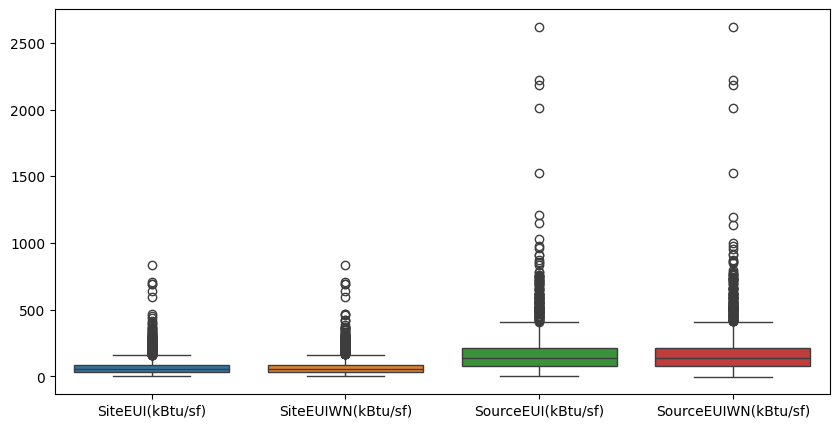

In [30]:
# Select only numeric columns
df_numeric = raw_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "(kBtu/sf)" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

<Figure size 1000x500 with 0 Axes>

<Axes: >

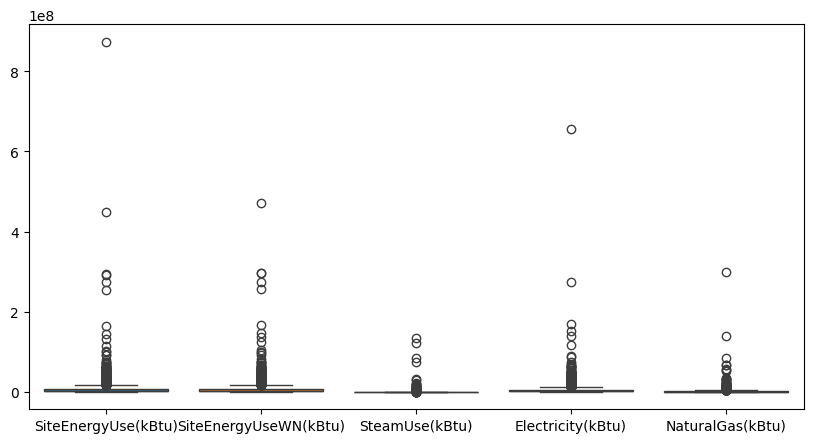

In [31]:
# Select only numeric columns
df_numeric = raw_data.select_dtypes(include=['number'])

#Select columns
columns_to_keep = []
for column in df_numeric.columns:
    if "(kBtu)" in column:
        columns_to_keep.append(column)

df_numeric = df_numeric[columns_to_keep]

# Convert to long format (for Seaborn)
# df_melted = df_numeric.melt(var_name="Variable", value_name="Value")

# Plot boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_numeric)
# plt.xticks(rotation=45)
# plt.title("Distribution des variables numériques standardisées")
plt.show()

Matrice de corrélation

([<matplotlib.axis.XTick at 0x7f6ca122afd0>,
 [Text(0, 0, 'OSEBuildingID'),
  Text(1, 0, 'DataYear'),
  Text(2, 0, 'ZipCode'),
  Text(3, 0, 'CouncilDistrictCode'),
  Text(4, 0, 'Latitude'),
  Text(5, 0, 'Longitude'),
  Text(6, 0, 'YearBuilt'),
  Text(7, 0, 'NumberofBuildings'),
  Text(8, 0, 'NumberofFloors'),
  Text(9, 0, 'PropertyGFATotal'),
  Text(10, 0, 'PropertyGFAParking'),
  Text(11, 0, 'PropertyGFABuilding(s)'),
  Text(12, 0, 'LargestPropertyUseTypeGFA'),
  Text(13, 0, 'SecondLargestPropertyUseTypeGFA'),
  Text(14, 0, 'ThirdLargestPropertyUseTypeGFA'),
  Text(15, 0, 'ENERGYSTARScore'),
  Text(16, 0, 'SiteEUI(kBtu/sf)'),
  Text(17, 0, 'SiteEUIWN(kBtu/sf)'),
  Text(18, 0, 'SourceEUI(kBtu/sf)'),
  Text(19, 0, 'SourceEUIWN(kBtu/sf)'),
  Text(20, 0, 'SiteEnergyUse(kBtu)'),
  Text(21, 0, 'SiteEnergyUseWN(kBtu)'),
  Text(22, 0, 'SteamUse(kBtu)'),
  Text(23, 0, 'Electricity(kWh)'),
  Text(24, 0, 'Electricity(kBtu)'),
  Text(25, 0, 'NaturalGas(therms)'),
  Text(26, 0, 'NaturalGas(kBtu)')

([<matplotlib.axis.YTick at 0x7f6ca122b750>,
 [Text(0, 0, 'OSEBuildingID'),
  Text(0, 1, 'DataYear'),
  Text(0, 2, 'ZipCode'),
  Text(0, 3, 'CouncilDistrictCode'),
  Text(0, 4, 'Latitude'),
  Text(0, 5, 'Longitude'),
  Text(0, 6, 'YearBuilt'),
  Text(0, 7, 'NumberofBuildings'),
  Text(0, 8, 'NumberofFloors'),
  Text(0, 9, 'PropertyGFATotal'),
  Text(0, 10, 'PropertyGFAParking'),
  Text(0, 11, 'PropertyGFABuilding(s)'),
  Text(0, 12, 'LargestPropertyUseTypeGFA'),
  Text(0, 13, 'SecondLargestPropertyUseTypeGFA'),
  Text(0, 14, 'ThirdLargestPropertyUseTypeGFA'),
  Text(0, 15, 'ENERGYSTARScore'),
  Text(0, 16, 'SiteEUI(kBtu/sf)'),
  Text(0, 17, 'SiteEUIWN(kBtu/sf)'),
  Text(0, 18, 'SourceEUI(kBtu/sf)'),
  Text(0, 19, 'SourceEUIWN(kBtu/sf)'),
  Text(0, 20, 'SiteEnergyUse(kBtu)'),
  Text(0, 21, 'SiteEnergyUseWN(kBtu)'),
  Text(0, 22, 'SteamUse(kBtu)'),
  Text(0, 23, 'Electricity(kWh)'),
  Text(0, 24, 'Electricity(kBtu)'),
  Text(0, 25, 'NaturalGas(therms)'),
  Text(0, 26, 'NaturalGas(kBtu)')

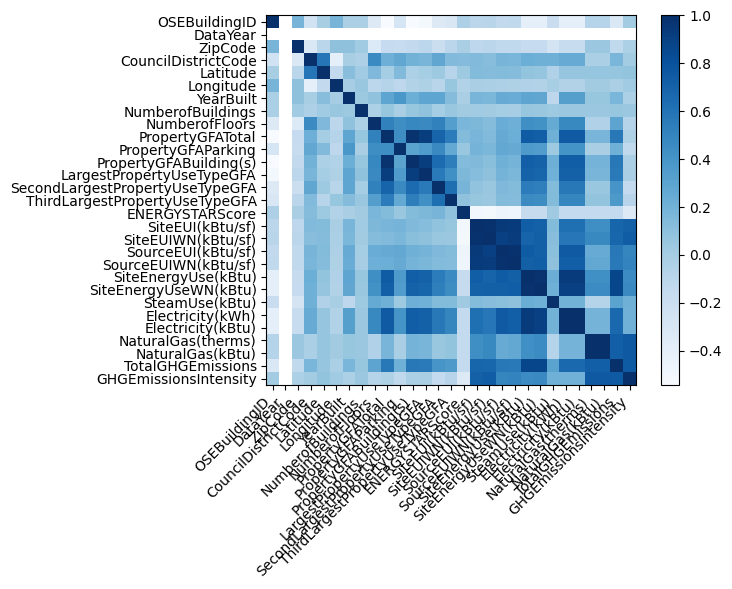

In [32]:
matrix = raw_data.corr(method = 'spearman', numeric_only = True)

# plotting correlation matrix
plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

# Sélection des variables et séparation des données en train et test

La première variable cible qui nous intéresse est la consommation d'énergie totale, normalisé par rapport aux données météo. Dans le dataset, il s'agit de la colonne SiteEnergyUseWN <br> 
Pour la prédire, on va utiliser les variables qui paraissent, d'un point de vue métier et des corrélations calculées ci-dessus, en lien avec elle : 
- NumberofBuildings
- NumberofFloors
- PropertyGFABuilding(s)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

Nous disposons aussi de variables catégorielles potentiellement intéressantes : 
- PrimaryPropertyType
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType

In [33]:
data_selected = raw_data[['NumberofBuildings','NumberofFloors','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                          'ThirdLargestPropertyUseTypeGFA','PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
                          'SiteEnergyUseWN(kBtu)','TotalGHGEmissions']] 

<Axes: >

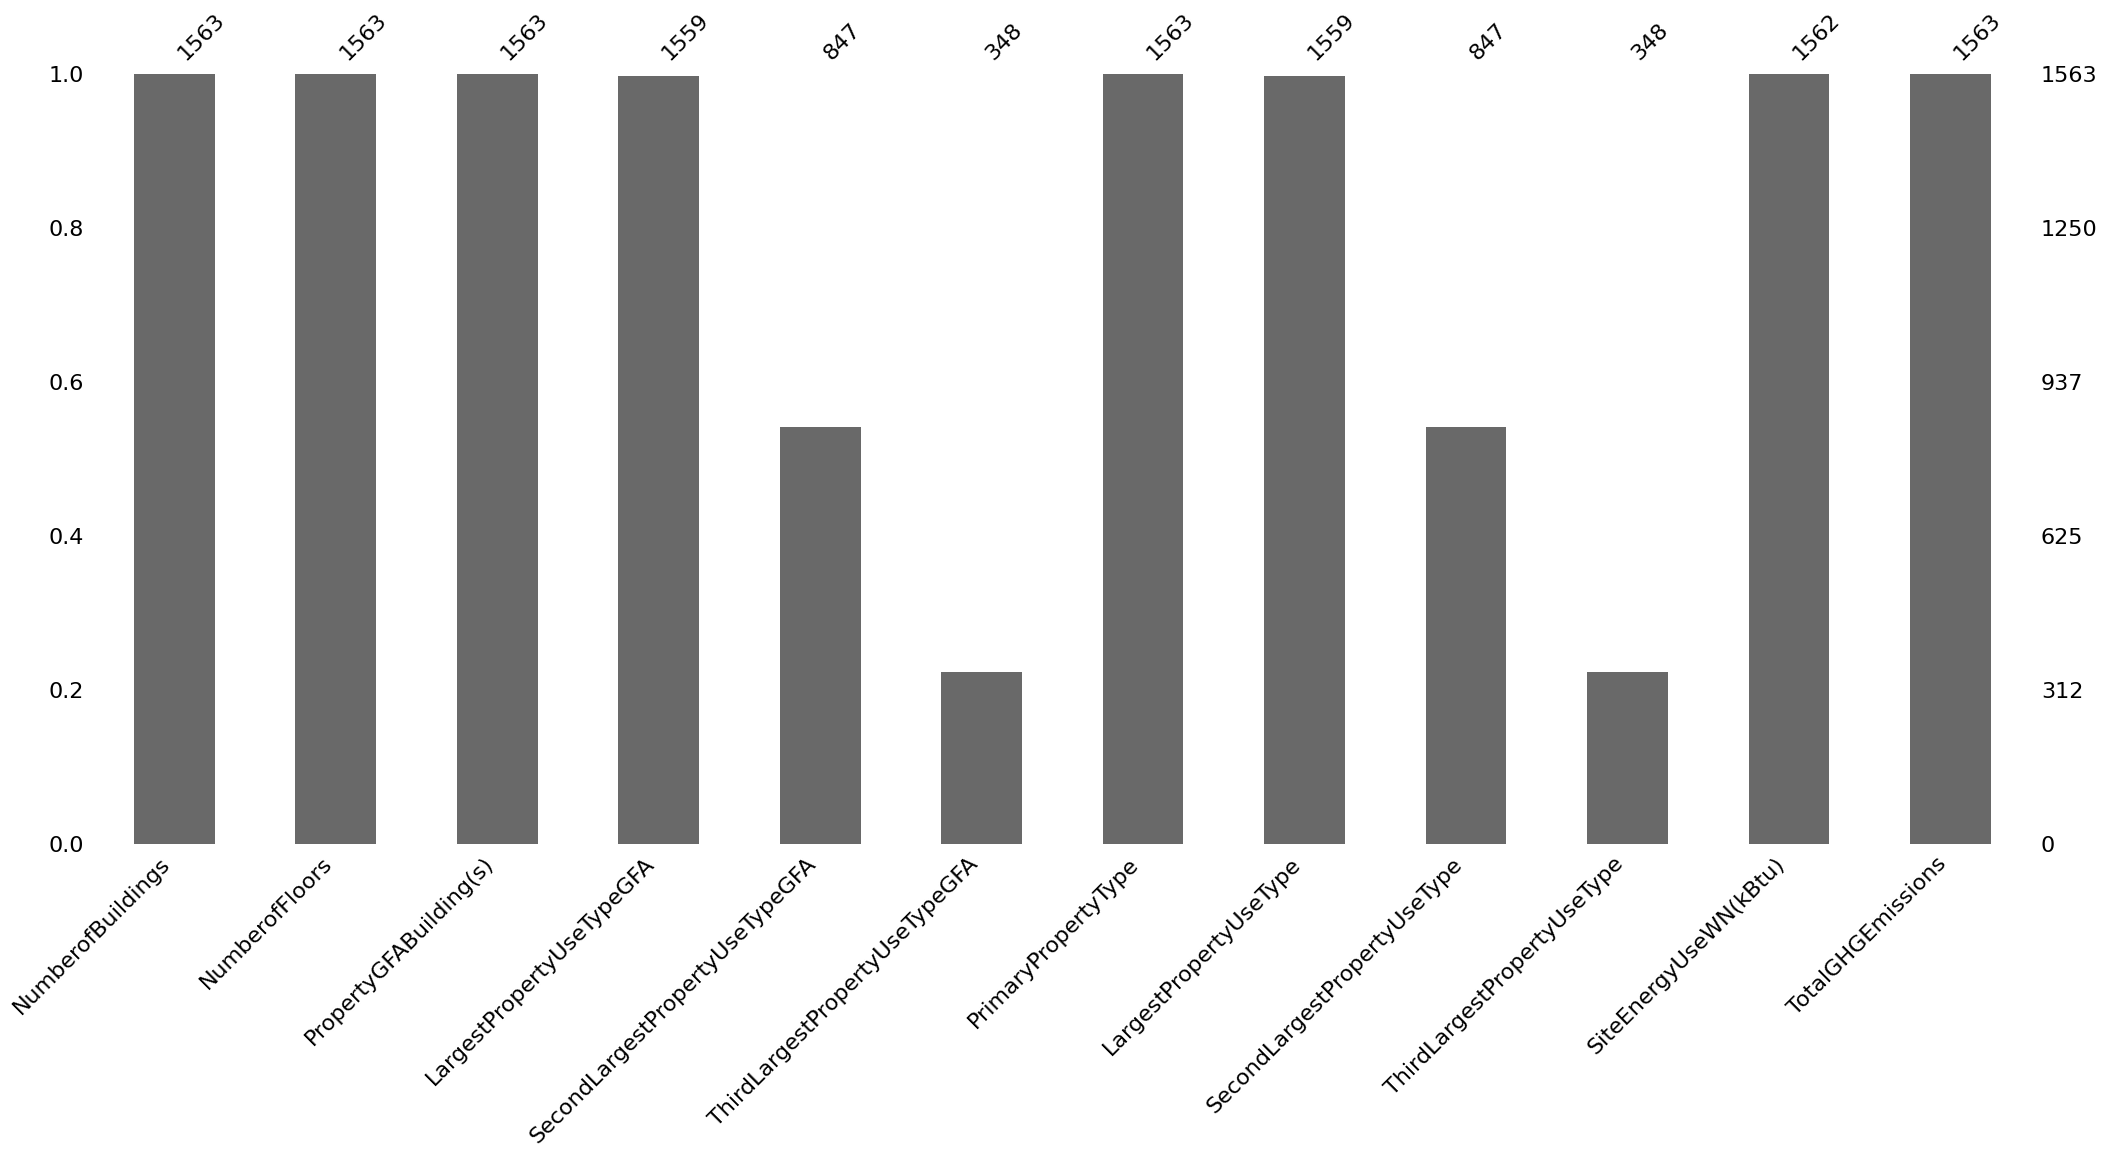

In [34]:
msno.bar(data_selected)

On enlève les propriétés qui n'ont pas de valeur cible et qui ont des nan dans leurs variables explicatives. Toutes les propriétés n'ont pas plusieurs batiments donc ne peuvent pas toutes avoir de valeurs dans les colonnes du type 'SecondLargest' et 'ThirdLargest'. Il ne s'agit donc pas de réelles valeurs manquantes donc les remplace par 0 ou 'Inexistant' en fonction tu type de variable

In [35]:
data_selected.loc[data_selected['SecondLargestPropertyUseTypeGFA'].isnull(),'SecondLargestPropertyUseTypeGFA'] = 0
data_selected.loc[data_selected['ThirdLargestPropertyUseTypeGFA'].isnull(),'ThirdLargestPropertyUseTypeGFA'] = 0

data_selected.loc[data_selected['SecondLargestPropertyUseType'].isnull(),'SecondLargestPropertyUseType'] = 'none'
data_selected.loc[data_selected['ThirdLargestPropertyUseType'].isnull(),'ThirdLargestPropertyUseType'] = 'none'

In [36]:
data_selected.dropna(inplace = True)

/tmp/ipykernel_80471/2137253860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected.dropna(inplace = True)


<Axes: >

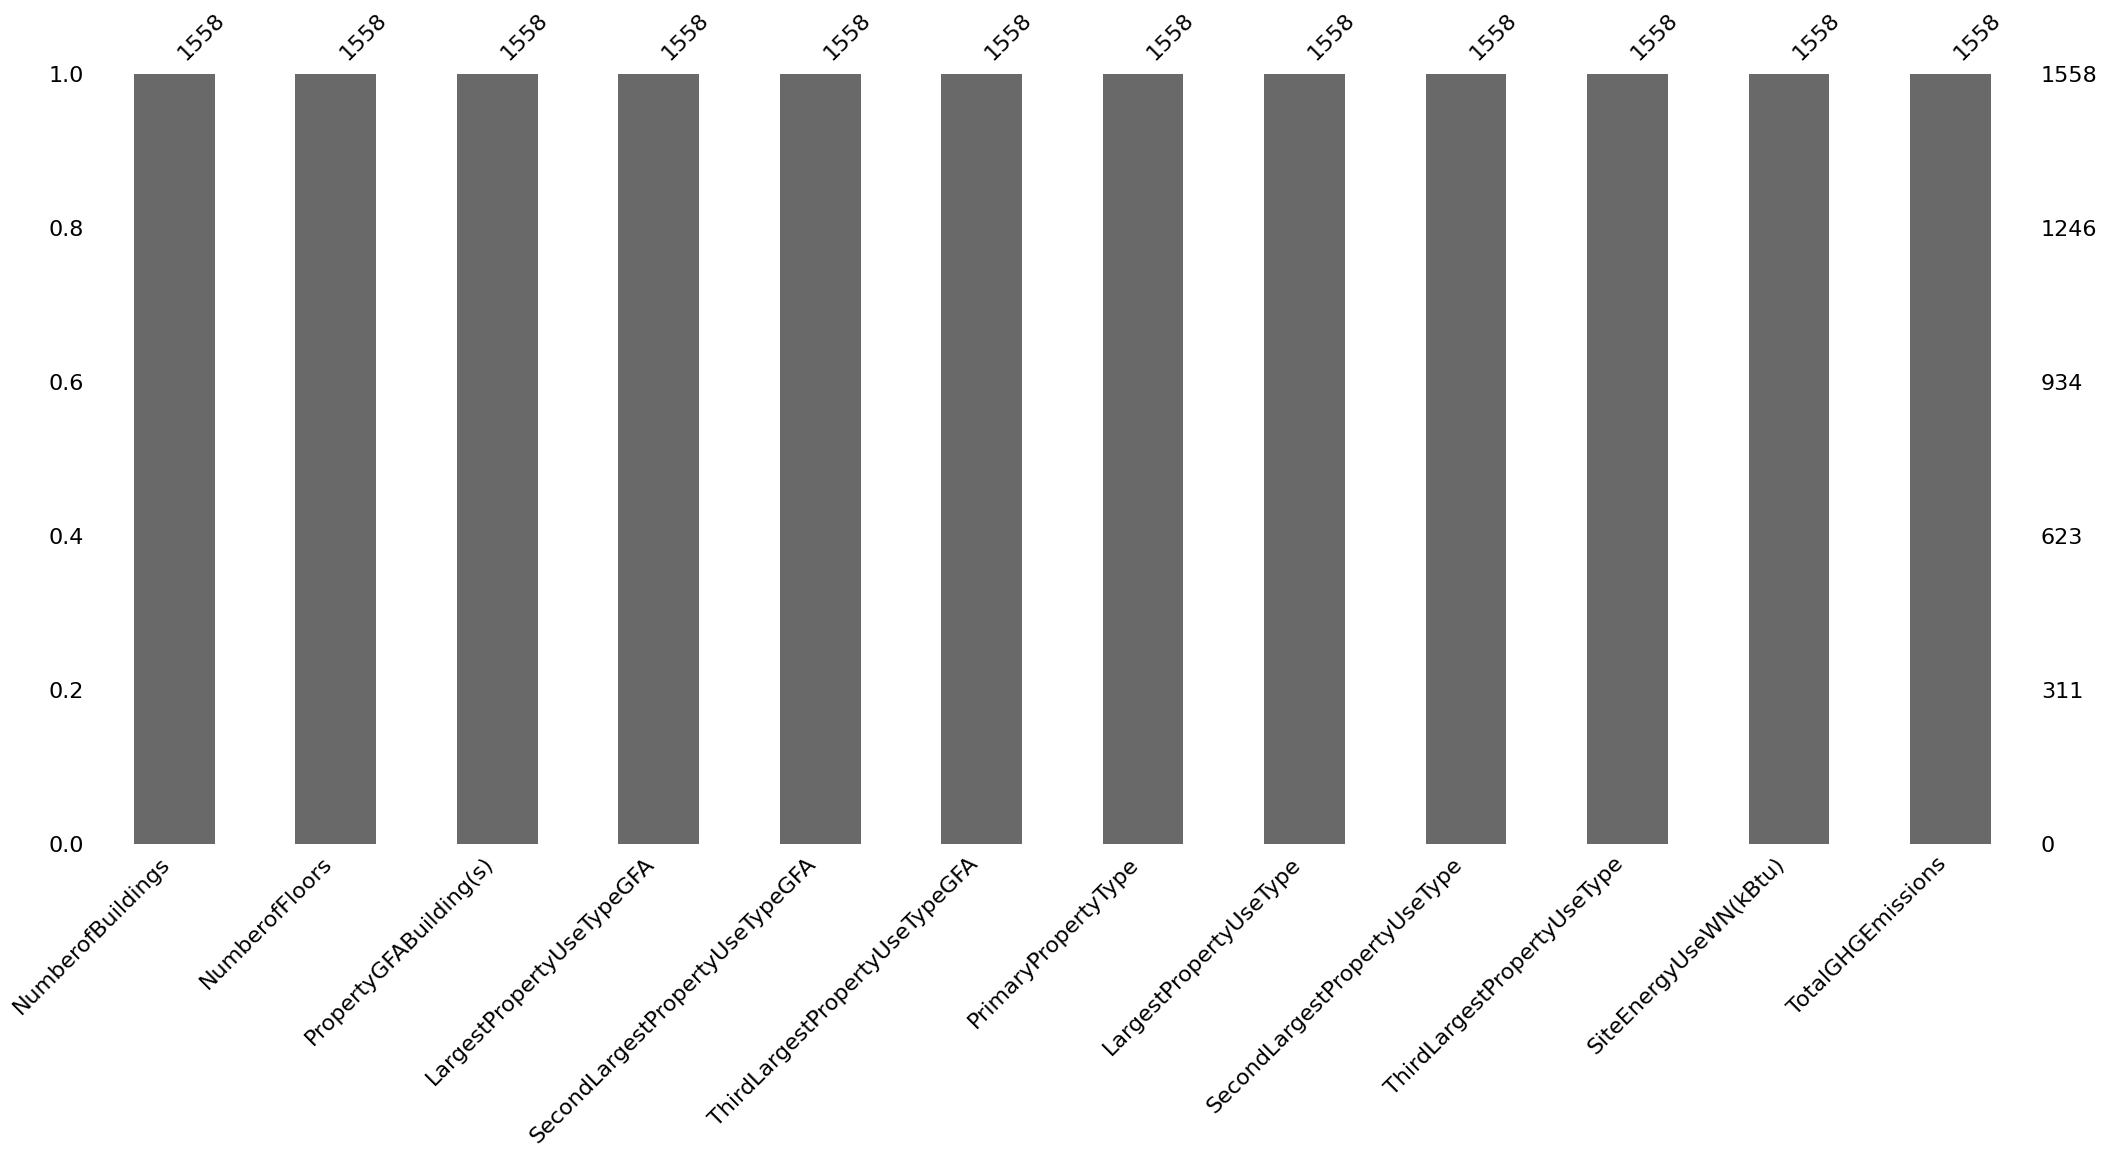

In [37]:
msno.bar(data_selected)

## Séparation des données en train et test

In [38]:
X = data_selected.iloc[:,0:-2] #On enlève l'émission de gaz à effet de serre et la variable cible. 
y = data_selected['SiteEnergyUseWN(kBtu)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
num_var = ['NumberofBuildings','NumberofFloors','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']
cat_var = ['LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']

In [40]:
y.describe()

count    1.558000e+03
mean     8.414993e+06
std      2.272772e+07
min      0.000000e+00
25%      1.295210e+06
50%      2.788274e+06
75%      7.454687e+06
max      4.716139e+08
Name: SiteEnergyUseWN(kBtu), dtype: float64

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

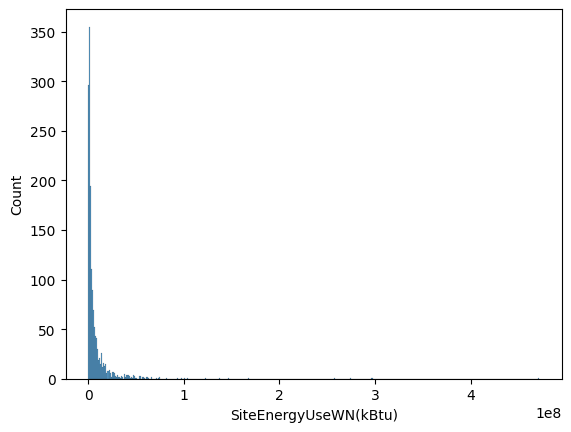

In [41]:
sns.histplot(y)

# Utilisation des variables quantitatives seules

In [42]:
X_train_numeric = X_train[num_var]
X_test_numeric = X_test[num_var]

## Modèle dummy (baseline)

In [43]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [44]:
# Define pipeline
dummy_regressor = DummyRegressor()
pipe_dummy = make_pipeline(dummy_regressor)
cross_val_score(pipe_dummy, X_train_numeric, y_train, cv = 5, 
                scoring = 'neg_root_mean_squared_error')

array([-12437626.89969767, -13787884.21553959, -29594297.01798501,
       -20243073.97806206, -16878915.8055822 ])

Penser à calculer le score moyen

In [45]:
y_train.mean()
y_test.mean()

np.float64(8316284.162733098)

np.float64(8809197.143485354)

- RMSE (Root Mean Squared Error) a la même unité que la variable cible et est très sensible aux outliers. Dépend de l'envergure de la variable cible et donc .... La valeur doit être minimisée
- MAE (mean absolute error) a la même unité que la variable cible et est moins sensible aux outliers que RMSE. Dépend de l'envergure de la variable cible et donc .... La valeur doit être minimisée
- R2 mesure l'éloignement par rapport à un modèle dummy : (1 - erreur_cumulée_modèle/erreur_cumulée_dummy)' La valeur doit être maximisée vers 1.

Il existe de nombreuses autres métriques pour la régression : https://scikit-learn.org/stable/api/sklearn.metrics.html#regression-metrics

Le R2 est négatif! C'est vraiment un mauvais modèle, encore plus nul que le modèle dummy utilisé en interne. 

## Régresseur linéaire

Le modèle de régression linéaire a besoin d'une normalisation des features au préalable. On commence par explorer les différents transformers associées à la normalisation :
- MinMaxScaler
- StandardScaler
- RobustScaler

Tester aussi le power transformer. Intéressant pour les variables très dissymétriques. Transfo avec logarithme un peu naif, power transfo est plus général qui contient une famille de tranfo type logarithme etc.. et choisit la plus adaptée à la donnée. Va réduire la squewness. 
Regarder la doc. 

array([[0.00900901, 0.02020202, 0.00949324, 0.0092837 , 0.        ,
        0.        ],
       [0.00900901, 0.01010101, 0.00390146, 0.00274067, 0.01992975,
        0.        ],
       [0.00900901, 0.02020202, 0.00214286, 0.00192646, 0.        ,
        0.        ],
       ...,
       [0.00900901, 0.03030303, 0.00514312, 0.00520629, 0.00147208,
        0.        ],
       [0.00900901, 0.02020202, 0.00674726, 0.00653186, 0.        ,
        0.        ],
       [0.00900901, 0.02020202, 0.00253678, 0.00153857, 0.0169969 ,
        0.        ]], shape=(1246, 6))

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

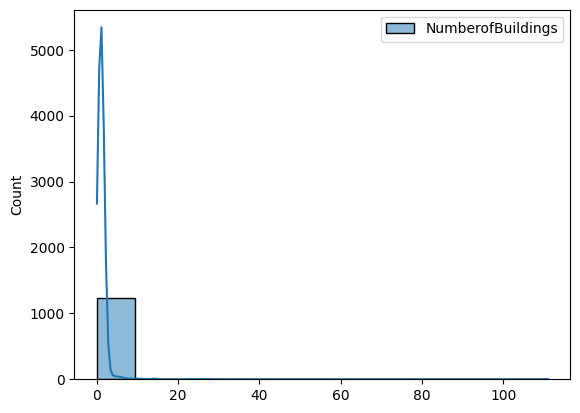

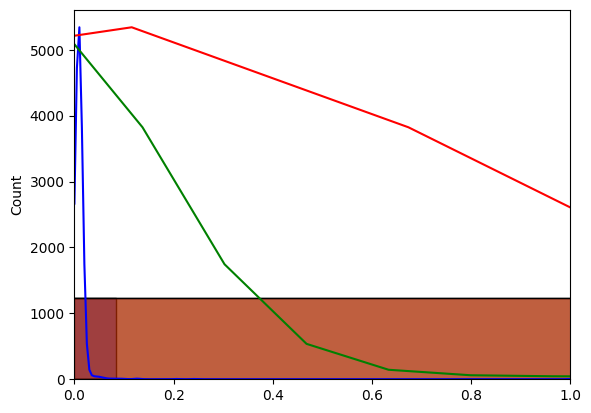

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

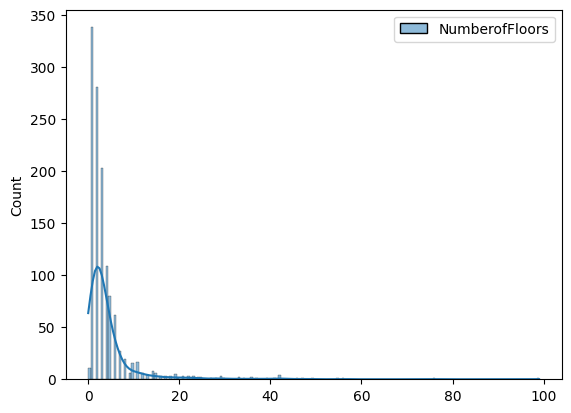

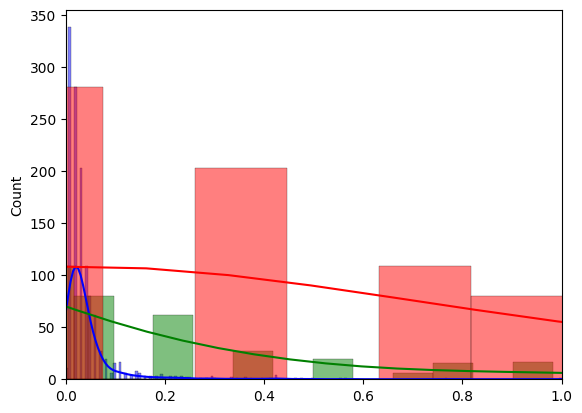

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

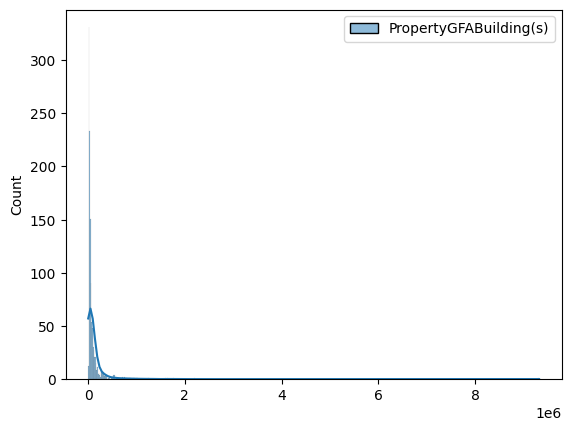

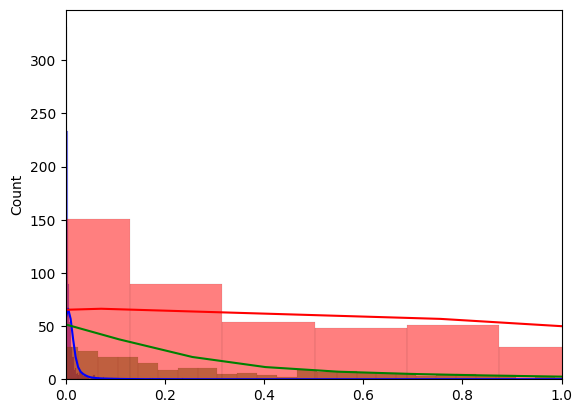

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

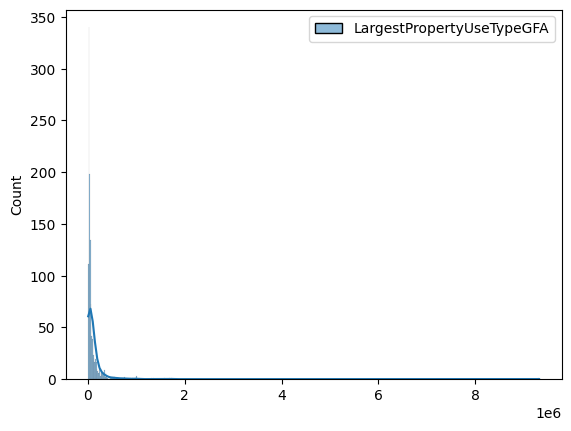

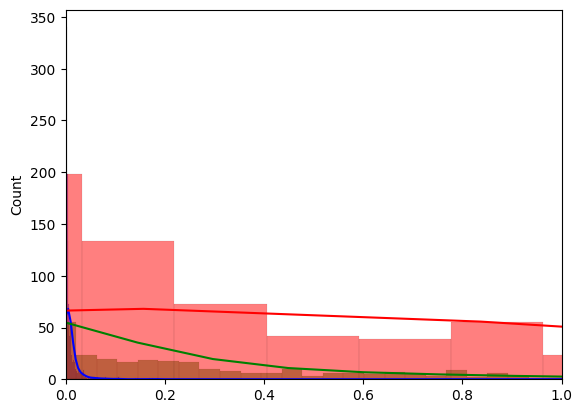

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

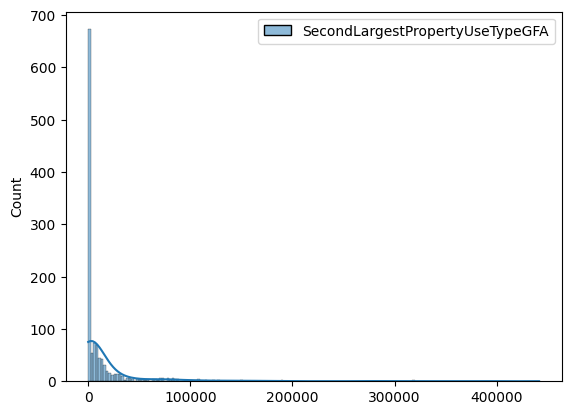

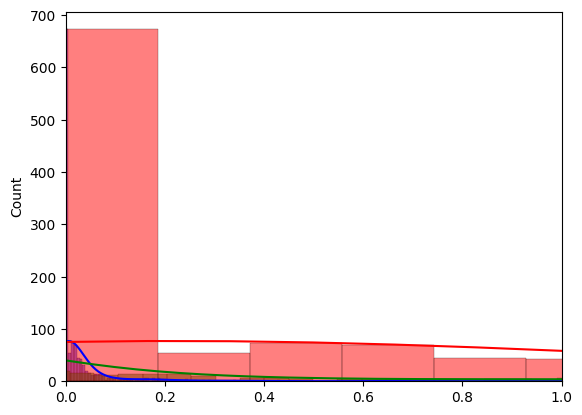

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

<Axes: ylabel='Count'>

(0.0, 1.0)

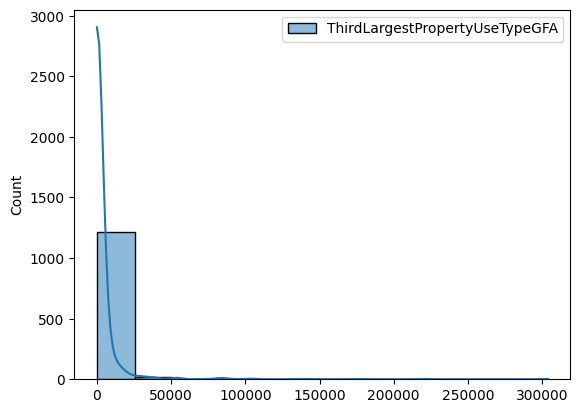

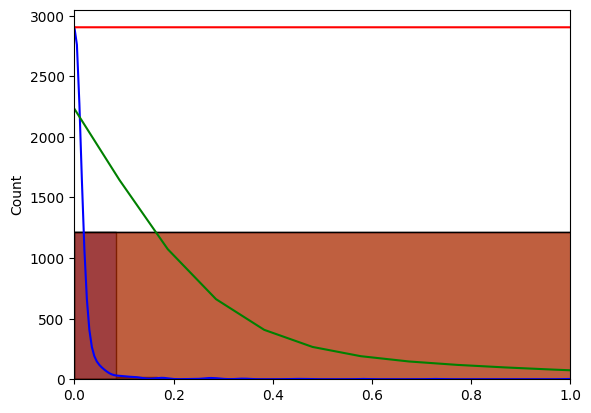

In [50]:
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_train_numeric)
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X_train_numeric)
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_train_numeric)


X_minmax

for idx, num_var in enumerate(X_train_numeric.columns): 
    plt.figure()
    sns.histplot(X_train_numeric[[num_var]], kde = True, color = 'black', label = 'sans transformation', alpha = 0.5)
    plt.figure()
    sns.histplot(X_minmax[:,idx], kde = True, color = 'blue', label = 'minmax', alpha = 0.5)
    sns.histplot(X_standard[:,idx], kde = True, color = 'green', label = 'standard', alpha = 0.5)
    sns.histplot(X_robust[:,idx], kde = True, color = 'red', label = 'robust', alpha = 0.5)
    plt.xlim((0,1))
    plt.show()

Les résultats des 3 scalers semblent se superposer. La méthode de scaling, pour nos données, semble donc indifférente.

In [47]:
#définir le pipeline
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
reg = LinearRegression()
model_LinReg = make_pipeline(scaler, reg)
model_LinReg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

#Tester les différents scaler et choisir celui qui renvoie les meilleurs résultats.

In [48]:
# evaluate pipeline with cross validation
cross_val_score(model_LinReg, X_train_numeric, y_train, cv = 5, 
                scoring = 'neg_root_mean_squared_error')
# en optimisant les paramètres du régresseur linéaire
params = [

]
grid = GridSearchCV(model_LinReg, param_grid= params, cv = 5, 
                scoring = 'neg_root_mean_squared_error')
grid.fit(X_train_numeric, y_train)
grid.best_params
#Mais il n'y a pas de paramètres à optimiser pour la régression linéaire

array([ -7190932.77575886, -13776054.40572785, -59544439.17029611,
       -18884977.93354086, -13308379.56720771])

ValueError: No fits were performed. Was the CV iterator empty? Were there no candidates?

Introduire une pénalité pour empecher que les coeffs ne soient trop grands car source d'erreurs dans le modèle. LASRI(l1) et RIDGE = 2 techniques de régularisation. l1 peut tuer des variables. Ces techniques ont un param de régularisation. Permet de réduire l'overfitting. Tradeoff : trouver le paramètre optimal --> GridSearch.
On peut passer directement à ElasticNet(proportion de lasso et ridge et param de régularisation) et Rifge et Lasso pour régler les pénalités.  

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define pipeline with StandardScaler and Ridge regression
steps = [
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
]

pipeline = Pipeline(steps)

# Define parameter grid for alpha values
param_grid = {
    'ridge__alpha': np.logspace(-6, 10, 20)  # Search from 10^-4 to 10^2
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    return_train_score=True,
    cv=5,
    scoring='r2'
)

# Fit the grid search to your data
grid_search.fit(X_train_numeric, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_}")  # Negative because we used neg_mean_squared_error
pd.DataFrame(grid_search.cv_results_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.00000000e-06, 6.95192796e-06, 4.83293024e-05, 3.35981829e-04,
       2.33572147e-03, 1.62377674e-02, 1.12883789e-01, 7.84759970e-01,
       5.45559478e+00, 3.79269019e+01, 2.63665090e+02, 1.83298071e+03,
       1.27427499e+04, 8.85866790e+04, 6.15848211e+05, 4.28133240e+06,
       2.97635144e+07, 2.06913808e+08, 1.43844989e+09, 1.00000000e+10])},
             return_train_score=True, scoring='r2')

Best parameters: {'ridge__alpha': np.float64(1832.9807108324376)}
Best score: -0.17814395488028997


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002179,0.000661,0.000953,0.000086,1.000000e-06,{'ridge__alpha': 1e-06},0.658221,0.001338,-3.075065,0.129584,0.377794,-0.381626,1.365329,20,3.616079e-01,4.183408e-01,5.721275e-01,4.512262e-01,3.874708e-01,4.381546e-01,7.340360e-02
1,0.001773,0.000244,0.000871,0.000052,6.951928e-06,{'ridge__alpha': 6.951927961775606e-06},0.658221,0.001338,-3.075065,0.129584,0.377794,-0.381626,1.365329,19,3.616079e-01,4.183408e-01,5.721275e-01,4.512262e-01,3.874708e-01,4.381546e-01,7.340360e-02
2,0.001682,0.000193,0.000825,0.000059,4.832930e-05,{'ridge__alpha': 4.8329302385717524e-05},0.658222,0.001339,-3.075065,0.129584,0.377794,-0.381625,1.365329,18,3.616079e-01,4.183408e-01,5.721275e-01,4.512262e-01,3.874708e-01,4.381546e-01,7.340360e-02
3,0.001512,0.000122,0.000835,0.000037,3.359818e-04,{'ridge__alpha': 0.0003359818286283781},0.658226,0.001347,-3.075064,0.129585,0.377792,-0.381623,1.365329,17,3.616079e-01,4.183408e-01,5.721275e-01,4.512262e-01,3.874708e-01,4.381546e-01,7.340360e-02
4,0.001446,0.000068,0.000797,0.000028,2.335721e-03,{'ridge__alpha': 0.002335721469090121},0.658256,0.001398,-3.075058,0.129591,0.377777,-0.381607,1.365333,16,3.616079e-01,4.183408e-01,5.721275e-01,4.512262e-01,3.874708e-01,4.381546e-01,7.340360e-02
5,0.001468,0.000073,0.000806,0.000042,1.623777e-02,{'ridge__alpha': 0.01623776739188721},0.658464,0.001753,-3.075012,0.129631,0.377672,-0.381498,1.365358,15,3.616078e-01,4.183406e-01,5.721275e-01,4.512261e-01,3.874707e-01,4.381545e-01,7.340364e-02
6,0.001422,0.000043,0.000777,0.000049,1.128838e-01,{'ridge__alpha': 0.11288378916846883},0.659882,0.004185,-3.074693,0.129910,0.376943,-0.380755,1.365525,14,3.616026e-01,4.183344e-01,5.721274e-01,4.512209e-01,3.874663e-01,4.381503e-01,7.340545e-02
7,0.001548,0.000155,0.000936,0.000117,7.847600e-01,{'ridge__alpha': 0.7847599703514607},0.668474,0.019485,-3.072431,0.131647,0.371752,-0.376215,1.366376,13,3.613826e-01,4.180706e-01,5.721218e-01,4.510016e-01,3.872886e-01,4.379730e-01,7.348028e-02
8,0.001461,0.000102,0.000786,0.000051,5.455595e+00,{'ridge__alpha': 5.455594781168514},0.695900,0.081125,-3.054930,0.138662,0.340558,-0.359737,1.364669,12,3.564777e-01,4.121298e-01,5.719062e-01,4.459998e-01,3.840460e-01,4.341119e-01,7.502729e-02
9,0.001464,0.000074,0.000764,0.000040,3.792690e+01,{'ridge__alpha': 37.92690190732246},0.706370,0.169099,-2.896966,0.154715,0.276094,-0.318138,1.304920,11,3.358091e-01,3.868049e-01,5.682894e-01,4.230215e-01,3.735884e-01,4.175027e-01,8.038874e-02


In [ ]:
# def perform_cross_validation(
#     X: pl.DataFrame,
#     y: pl.Series,
#     model,
#     cross_val_type,
#     scoring_metrics: tuple,
#     return_estimator=False,
#     groups=None,
# ):
#     try:
#         X = X.to_numpy()
#         y = y.to_numpy()
#     except:
#         pass
    
#     scores = cross_validate(
#         model,
#         X,
#         y,
#         cv=cross_val_type,
#         return_train_score=True,
#         return_estimator=return_estimator,
#         scoring=scoring_metrics,
#         groups=groups,
#     )

#     for metric in scoring_metrics:
#         print(
#             "Average Train {metric} : {metric_value}".format(
#                 metric=metric,
#                 metric_value=np.mean(scores["train_" + metric]),
#             )
#         )
#         print(
#             "Train {metric} Standard Deviation : {metric_value}".format(
#                 metric=metric, metric_value=np.std(scores["train_" + metric])
#             )
#         )

#         print(
#             "Average Test {metric} : {metric_value}".format(
#                 metric=metric, metric_value=np.mean(scores["test_" + metric])
#             )
#         )
#         print(
#             "Test {metric} Standard Deviation : {metric_value}".format(
#                 metric=metric, metric_value=np.std(scores["test_" + metric])
#             )
#         )

#     return scores

In [ ]:
# reg = LinearRegression()

# regression_scoring_metrics = ("r2", "neg_root_mean_squared_error", "neg_mean_absolute_error")

# scores_regressor = perform_cross_validation(
#     X=X_train_scaled,
#     y=y_train,
#     model=reg,
#     cross_val_type=5, #Par défaut, le nombre de folds est 5
#     scoring_metrics=regression_scoring_metrics,
# )

# Feature engineering

## Encodage du type de propriété

In [ ]:
len(data_selected['PrimaryPropertyType'].unique())

21

In [ ]:
enc = OneHotEncoder()
enc.fit_transform(data_selected[['PrimaryPropertyType']])
len(enc.get_feature_names_out())

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1558 stored elements and shape (1558, 21)>

21

In [ ]:
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1563 stored elements and shape (1563, 21)>

## Encodage des colonnes d'usage en colonnes numériques pondérées par les surfaces associées

In [ ]:
class PropertyUseTypeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categories_ = None  # Stockera les catégories uniques
    
    def fit(self, X, y=None):
        """Apprend les catégories uniques à partir des données."""
        self.categories_ = set(X['LargestPropertyUseType']).union(
            X['SecondLargestPropertyUseType'],
            X['ThirdLargestPropertyUseType']
        )
        self.categories_.discard(None)  # Supprime les valeurs None éventuelles
        return self  # Retourne l'objet pour le chaînage dans un pipeline

    def transform(self, X):
        """Transforme le DataFrame en encodant les types de propriétés en colonnes numériques."""
        X_transformed = X.copy()

        # Initialisation des nouvelles colonnes à 0
        for category in self.categories_:
            X_transformed[category] = (
                (X_transformed['LargestPropertyUseType'] == category) * X_transformed['LargestPropertyUseTypeGFA'] +
                (X_transformed['SecondLargestPropertyUseType'] == category) * X_transformed['SecondLargestPropertyUseTypeGFA'] +
                (X_transformed['ThirdLargestPropertyUseType'] == category) * X_transformed['ThirdLargestPropertyUseTypeGFA']
            )

        # Suppression des colonnes originales
        X_transformed.drop(columns=[
            'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
            'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'
        ], inplace=True)

        return X_transformed

## Création et exécution du pipeline de preprocessing

In [ ]:
property_usage_cols = ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType','LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
pipe_property_type = Pipeline([
    ('property_type_encoder', OneHotEncoder())
])
pipe_property_usage = Pipeline([
    ('property_usage_encoder', PropertyUseTypeEncoder())
])
cat_col_transformer = ColumnTransformer(transformers = [
    ('pipe_property_type', pipe_property_type, ['PrimaryPropertyType']),
    ('pipe_property_usage', pipe_property_usage, property_usage_cols)
],
    remainder='passthrough',
    n_jobs = -1
)
scaler = StandardScaler()
preprocessing_pipeline = make_pipeline(cat_col_transformer,scaler)

In [ ]:
preprocessing_pipeline.fit_transform(X_train,y_train)

array([[-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.33849201, -0.05625265],
       [-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.48322813, -0.22047142],
       [-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.33849201, -0.27211761],
       ...,
       [-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.19375589, -0.18400638],
       [-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.33849201, -0.13689624],
       [-0.18445839, -0.08529752, -0.23460201, ..., -0.0623422 ,
        -0.33849201, -0.26054892]], shape=(1246, 88))